# Orbital magnetic susceptibility
Author: [Soshun Ozaki](mailto:ozaki@hosi.phys.s.u-tokyo.ac.jp), [Takashi Koretsune](mailto:takashi.koretsune.c3@tohoku.ac.jp)

## Theory of the orbital magnetism
The orbital magnetism is the magnetism induced by a vector potential coupled with the momentum,
and is one of fundamental thermodynamic properties of itenerant systems.
A lot of efforts were dedicated to the formulation of the orbital magnetic susceptibility,
and the simple but complete formula was derived by Fukuyama [1]. 
Recently, a new formula for the tight-binding model, which is based on Fukuyama's formula,
has been derived and is applied to various lattice models[2,3,4].
These formulas are written in terms of the thermal Green's functions and suitable for the demonstration 
of the Matsubara summation using the IR basis.
We present codes for the computation of the orbital magnetic susceptibility using the newly developed formula for the tight-binding models on the two basic lattices, the square and honeycomb lattices.



## The orbital magnetic susceptibility formula
The orbital magnetic susceptibility formula for tight-binding models is given by
\begin{align*}
\chi &= k_B T\sum_n \chi(i \omega_n)\\
\chi(i \omega_n) &= \frac{e^2}{\hbar^2} \sum_{{\boldsymbol k}} {\rm Tr} 
[\gamma_x G \gamma_y G \gamma_x G \gamma_y G + \frac{1}{2} (\gamma_x G \gamma_y G + \gamma_y G \gamma_x G)\gamma_{xy} G]
\end{align*}
where $G=G(i\omega_n, {\boldsymbol k})$ is the thermal Green's function, 
$\gamma_i({\boldsymbol k})=\frac{\partial H_{\boldsymbol k}}{\partial k_i}, (i=x,y)$ 
and $\gamma_{xy}({\boldsymbol k})= \frac{\partial^2 H_{\boldsymbol k}}{\partial k_x \partial k_y}$ represent the derivative of 
the tight-binding Hamiltonian $H_{\boldsymbol k}$,
and $n$ summation represents the Matsubara summation.
We evaluate the orbital magnetic susceptibility for the square and honeycomb lattice model with transfer integral $t$, lattice constant $a$.
Note that these calculations for tight-binding models and continuum models are shown in 
Ref.[2,3] and Ref.[5,6], respectively.
In our practical implementation, we perform the Matsubara summation using the 'sparse ir' package, 
and ${\boldsymbol k}$ summation over the Brillouin zone is evaluated by  a simple discrete summation.
We show the results as functions of the chemical potential.

Ref:<br>
[1] H. Fukuyama, Prog. Theor. Phys. 45, 704 (1971).<br>
[2] G. Gómez-Santos and T. Stauber, Phys. Rev. Lett. 106, 045504 (2011).<br>
[3] A. Raoux, F. Piéchon, J. N. Fuchs, and G. Montambaux, Phys. Rev. B 91, 085120 (2015).<br>
[4] F. Piéchon, A. Raoux, J.-N. Fuchs, and G. Montambaux, Phys. Rev. B 94, 134423 (2016).<br>
[5] M. Ogata, J. Phys. Soc. of Jpn. 85, 064709 (2016).<br>
[6] M. Ogata, J. Phys. Soc. of Jpn. 85, 104708 (2016).

## Code implementation
We load basic modules used in the following.

In [1]:
import numpy as np
import scipy
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
import sparse_ir

#### Parameter setting
We use the units of $k_B=1$ in the following.
We set $t=a=1$ and $T = 0.1$.

In [2]:
t = 1         # hopping amplitude
a = 1         # lattice constant
T = 0.1       # temperature
beta = 1/T
wmax = 10
nk1 = 200
nk2 = 200
IR_tol = 1e-10
mu_range = np.linspace(-4.5, 4.5, 91)

#### Function for the orbital magnetic susceptibility
Here, we implement a function to calculate the orbital magnetic susceptibility from $H_{\boldsymbol k}$, $\gamma_x(\boldsymbol k)$, $\gamma_y(\boldsymbol k)$, and $\gamma_{xy}(\boldsymbol k)$.
First, we calculate $\chi(i \omega_n)$ for sampling Matsubara points and then obtain $k_B T\sum_n \chi(i \omega_n)$ using the IR basis.

In [3]:
def orbital_chi(IR_basis_set, hkgk, klist, mu_range):
    smpl_iwn = IR_basis_set.smpl_wn_f.wn
    chi_iw = np.zeros((len(mu_range), len(smpl_iwn)), dtype=complex)
    for k in klist:
        hk, gx, gy, gxy = hkgk(k)
        ek, v = np.linalg.eigh(hk)
        vd = np.conj(v.T)
        giw = 1/(1j * np.pi/IR_basis_set.beta * smpl_iwn[None,None,:] - (ek[:,None,None] - mu_range[None,:,None]))
        gx = vd @ gx @ v
        gy = vd @ gy @ v
        gxy = vd @ gxy @ v
        chi_iw += np.einsum("ab, bmn, bc, cmn, cd, dmn, da, amn->mn", 
                            gx, giw, gy, giw, gx, giw, gy, giw, optimize=True)
        chi_iw += (1/2) * np.einsum("ab, bmn, bc, cmn, ca, amn->mn",
                                    gx, giw, gy, giw, gxy, giw, optimize=True)
        chi_iw += (1/2) * np.einsum("ab, bmn, bc, cmn, ca, amn->mn",
                                    gy, giw, gx, giw, gxy, giw, optimize=True)
    chil = IR_basis_set.smpl_wn_f.fit(chi_iw, axis=1)
    smpl_tau0 = sparse_ir.TauSampling(IR_basis_set.basis_f, sampling_points=[0.0])
    chi_tau = smpl_tau0.evaluate(chil, axis=1)
    return chi_tau.real / len(klist)

We also implement a single band version of the function.

In [4]:
def orbital_chi1(IR_basis_set, hkgk, klist, mu_range):
    smpl_iwn = IR_basis_set.smpl_wn_f.wn
    chi_iw = np.zeros((len(mu_range), len(smpl_iwn)), dtype=complex)
    for k in klist:
        hk, gx, gy, gxy = hkgk(k)
        giw = 1/(1j * np.pi/IR_basis_set.beta * smpl_iwn[None,:] - (hk - mu_range[:,None]))
        chi_iw += gx**2 * gy**2 * giw**4
        chi_iw += gx * gy * gxy * giw**3
    chil = IR_basis_set.smpl_wn_f.fit(chi_iw, axis=1)
    smpl_tau0 = sparse_ir.TauSampling(IR_basis_set.basis_f, sampling_points=[0.0])
    chi_tau = smpl_tau0.evaluate(chil, axis=1)
    return chi_tau.real / len(klist)

We set the IR basis set and $\boldsymbol k$ mesh.

In [5]:
IR_basis_set = sparse_ir.FiniteTempBasisSet(beta=beta, wmax=wmax, eps=IR_tol)
kx_list = np.arange(nk1)/nk1
ky_list = np.arange(nk2)/nk2
klist = np.array(list(itertools.product(kx_list, ky_list)))

#### Two-dimensional square lattice
Now, we evaluate the orbital magnetic susceptibility as a function of chemical potential, $\chi(\mu)$, for the two-dimensional square lattice.

In [6]:
def hkgk_square(k):
    hk = -2 * t * (np.cos(2*np.pi*k[0]) + np.cos(2*np.pi*k[1]))
    gx = 2 * t * a * np.sin(2*np.pi*k[0])
    gy = 2 * t * a * np.sin(2*np.pi*k[1])
    gxy = 0
    return hk, gx, gy, gxy

chi_mu = orbital_chi1(IR_basis_set, hkgk_square, klist, mu_range)

For comparison, we calculate the analytic result at $T=0$ [3,5].

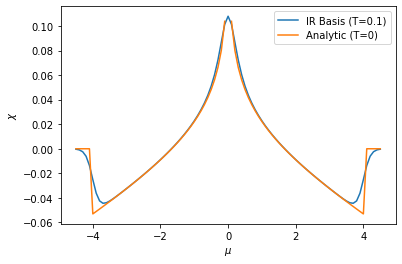

In [7]:
k = 1 - mu_range**2/16
chi_anltc = np.where(k >= 0, -(scipy.special.ellipe(k)-scipy.special.ellipk(k)/2)*(2/3)/np.pi**2, 0)

plt.plot(mu_range, chi_mu, label='IR Basis (T=0.1)')
plt.plot(mu_range, chi_anltc, label='Analytic (T=0)')
plt.xlabel("$\mu$")
plt.ylabel("$\chi$")
plt.legend()
plt.show()

#### Graphene
Next, we evaluate the orbital magnetic suscepitbility for graphene.

In [8]:
sq3 = np.sqrt(3)
def hkgk_graphene(k):
    kx, ky = 2*np.pi*k[0]/a, 2*np.pi*(k[0] + 2*k[1])/(a*sq3)
    h = -t * (np.exp(1j*ky*a/sq3) + 2 * np.cos(kx*a/2) * np.exp(-1j*ky*a/(2*sq3)))
    hk = np.array([ [ 0, h ], [ np.conj(h), 0 ] ])
    
    hx =  t * a * np.sin(kx/2) * np.exp(-1j*ky/(2*sq3))
    hy = -t * a * (1j/sq3 * (np.exp(1j*ky/sq3) - np.cos(kx/2) * np.exp(-1j*ky/(2*sq3))))
    gx = np.array([ [ 0, hx ], [ np.conj(hx), 0 ] ])
    gy = np.array([ [ 0, hy ], [ np.conj(hy), 0 ] ])
    
    hxy = -t * a * a * 1j/(2*sq3) * np.sin(kx/2) * np.exp(-1j*ky/(2*sq3))
    gxy = np.array([ [ 0, hxy ], [ np.conj(hxy), 0 ] ])

    return hk, gx, gy, gxy

chi_mu = orbital_chi(IR_basis_set, hkgk_graphene, klist, mu_range)

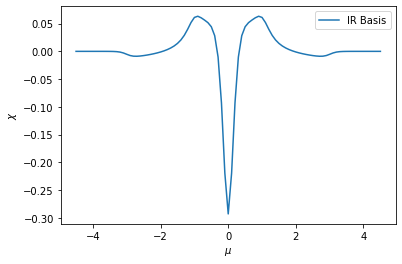

In [9]:
plt.plot(mu_range, chi_mu, label='IR Basis')
plt.xlabel("$\mu$")
plt.ylabel("$\chi$")
plt.legend()
plt.show()